![Credit Score](https://www.nfcc.org/wp-content/uploads/2020/09/bigstock-Credit-Score-Concept-Business-384487778-768x477.jpg)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm
import scipy.stats as sst
import warnings
from datetime import datetime
import plotly.express as px
from pandas import Series
import datatable as dt
from sklearn import metrics
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,MinMaxScaler, RobustScaler,OrdinalEncoder

from catboost import CatBoost,CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,Ridge
from sklearn.ensemble import RandomForestRegressor 


from sklearn.metrics import confusion_matrix,plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import operator
import time

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


%matplotlib inline

RANDOM_SEED = 47
warnings.simplefilter('ignore')

ModuleNotFoundError: No module named 'statsmodels'

# 0. Prepare funcs

In [304]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def test_model_roc_cm(X_test,y_test):
    proba = model.predict_proba(X_test)[:, 1]
    plot_roc_curve(y_test, proba)

    axs = plot_grid(2, figsize=(800/72, 300/72))
    plot_cmatrix(model, X_test, y_test, title='Абсолютные значения', display_labels=['0', '1'], ax=axs[0]);
    plot_cmatrix(model, X_test, y_test, title='Нормализованные значения', 
                 normalize='pred', display_labels=['0', '1'], ax=axs[1]);
def plot_cmatrix(model, X, y, title=None, **kwargs):
    disp = plot_confusion_matrix(model, X_test, y_test, **kwargs)
    disp.ax_.set_ylabel('Истинный класс')
    disp.ax_.set_xlabel('Предсказанный класс')
    if title:
        disp.ax_.set_title(title)
        
def plot_grid(nplots, max_cols=2, figsize=(800/72, 600/72)):
    ncols = min(nplots, max_cols)
    nrows = (nplots // ncols) + min(1, (nplots % ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize, constrained_layout=True)
    if nrows == 1:
        return axs
    return [axs[index // ncols, index % ncols] for index in range(nplots)]    
def prepare_space(df, num_features, bin_features, cat_features, target,scaler):
    if scaler is None:
        scaler = StandardScaler()
    X_num = scaler.fit_transform(df[num_features].values)
    X_bin = df[bin_features].values
    X_cat = OneHotEncoder(sparse=False).fit_transform(df[cat_features].values)
    X = np.hstack([X_num, X_bin, X_cat])
    Y = df[target].values
    return X, Y
def prepare_space_with_poly(df, num_features, bin_features, cat_features, target,scaler):
    if scaler is None:
        scaler = StandardScaler()
    poly = PolynomialFeatures(2)
    x_p = poly.fit_transform(df[num_cols].values)
    X_num = scaler.fit_transform(x_p)
    X_bin = df[bin_features].values
    X_cat = OneHotEncoder(sparse=False).fit_transform(df[cat_features].values)
    X = np.hstack([X_num, X_bin, X_cat])
    Y = df[target].values
    return X, Y
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def test_model_roc_cm(model, X_test,y_test):
    try:
        proba = model.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test, proba)

        axs = plot_grid(2, figsize=(800/72, 300/72))
        plot_cmatrix(model, X_test, y_test, title='Абсолютные значения', display_labels=['0', '1'], ax=axs[0]);
        plot_cmatrix(model, X_test, y_test, title='Нормализованные значения', 
                     normalize='pred', display_labels=['0', '1'], ax=axs[1]);
    except Exception as e:
        proba = model.predict(X_test)#[:, 1]
        plot_roc_curve(y_test, proba)

        axs = plot_grid(2, figsize=(800/72, 300/72))
        plot_cmatrix(model, X_test, y_test, title='Абсолютные значения', display_labels=['0', '1'], ax=axs[0]);
        plot_cmatrix(model, X_test, y_test, title='Нормализованные значения', 
                     normalize='pred', display_labels=['0', '1'], ax=axs[1]);
        print(e)
        return proba

In [305]:
 # класс для построения визуализация для числового признака и нахождения выбросов.

class AnalyzNumCol():
    def __init__(self, df, col):
        self.df = df[col]
        self.col = col
        self.col_log = LogDf(df, col).col_log
        self.df_log = LogDf(df, col).df_col_log()
    
    def show_plots(self, size = 5, log = False):
        
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        f = plt.figure()
        f.clear()
        plt.close(f)

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (3*size,size))
        
        fig.suptitle('Histogram, QQ-plot and boxplot for {0} '.format(column))
        ax1.hist(data.dropna(), bins = 20, histtype = 'bar', align = 'mid', rwidth = 0.8, color = 'red')
        fig = sm.qqplot(data.dropna(), fit = True, line ='45', ax=ax2) 
        
        
        
        ax3.boxplot(data.dropna(), vert = False)  # выбросы
     
        plt.show
        
    def emission_limits(self, log = False): # границы выбросов
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col
        
        q1 = data.quantile(q = 0.25) 
        q3 = data.quantile(q = 0.75) 
        IQR = q3 - q1
        return q1 - 1.5*IQR, q3 + 1.5*IQR

    def amount_emissions(self, log = False): 
        if log:
            data = self.df_log
            column = self.col_log
        else:
            data = self.df
            column = self.col

        minb, maxb = self.emission_limits(log)
        return len(data[data < minb])+ len(data[data > maxb])

    
# класс логарифмирования признака
    
class LogDf(): 
    def __init__(self, df, col):
        self.df = df
        self.col = col
        self.col_log = col + '_log'
        
    def df_col_log(self):      
        return  self.df[self.col].apply(lambda x: np.log(x + 1)) 

In [306]:
# метрика для оценки модели

class MatrixModel(): 
    def __init__(self, model, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = model.predict(X_test)
        self.probs = model.predict_proba(X_test)[:,1]
    
    def roc_curve_plot(self):
        fpr, tpr, threshold = roc_curve(self.y_test, self.probs)
        roc_auc = roc_auc_score(self.y_test, self.probs)

        plt.figure()
        plt.plot([0, 1], label='Baseline', linestyle='--')
        plt.plot(fpr, tpr, label = 'Regression')
        plt.title('Logistic Regression ROC AUC = %0.10f' % roc_auc)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc = 'lower right')
        plt.show()
    
    def confusion_matrix_plot(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        cf_matrix = np.array([[tp,fp],[fn,tn]])
        group_names = ['TP','FP','FN','TN']
        group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        plt.figure()
        sns.heatmap(cf_matrix, annot=labels, annot_kws={"size": 20}, fmt='', cmap= 'spring', cbar = False, \
                 xticklabels = ['Дефолт','Не дефолт'], yticklabels= ['Дефолт','Не дефолт'])
        plt.title('Матрица ошибок для default')
        plt.show()
        
    def get_metrics(self):
        result = pd.Series({
            'accuracy' : accuracy_score(self.y_test, self.y_pred),
            'precision' : precision_score(self.y_test, self.y_pred),
            'recall' : recall_score(self.y_test, self.y_pred),
            'F1' : f1_score(self.y_test, self.y_pred),
            'ROC_AUC': roc_auc_score(self.y_test, self.probs) 
        })
        return result
    
    def recall_precision_plot(self):
        precisions, recalls, _ = precision_recall_curve(self.y_test, self.y_pred)
        ap = average_precision_score(self.y_test, self.y_pred)        
        
        plt.figure()
        
        plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color='lime')
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title('Recall-precision curve, площадь под кривой = %0.10f' % ap)
        plt.grid(True)

        plt.show()

In [307]:
def test_models(models, X, y, iterations = 100):
    results = {}
    for i in models:
        rauc_train = []
        rauc_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
            rauc_test.append(metrics.roc_auc_score(y_test, models[i].fit(X_train, y_train).predict(X_test)))
            rauc_train.append(metrics.roc_auc_score(y_train, models[i].fit(X_train, y_train).predict(X_train)))
        results[i] = [np.mean(rauc_train), np.mean(rauc_test)]
    return pd.DataFrame(results)

In [308]:
%time 

#df_train = dt.fread('../input/sf-dst-scoring/train.csv').to_pandas()
#df_test = dt.fread('../input/sf-dst-scoring/test.csv').to_pandas()
#sample_submission = dt.fread('../input/sf-dst-scoring/sample_submission.csv').to_pandas()

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10.3 µs


In [309]:
%time 
data_directory = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(data_directory+'train.csv')
df_test = pd.read_csv(data_directory+'test.csv')
sample_submission = pd.read_csv(data_directory+'/sample_submission.csv')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [310]:
print('данные для обучения')
df_train.info()

данные для обучения
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73

In [311]:
print('данные для проверки')
df_test.info()

данные для проверки
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36

In [312]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


# 1. Import data

In [313]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

#data = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем
data = pd.concat([df_train, df_test], ignore_index=True)

# num of unique values, first 10 unique values, null values count, type
data.agg({'nunique', lambda s: s.unique()[:10]})\
    .append(pd.Series(data.isnull().sum(), name='null'))\
    .append(pd.Series(data.dtypes, name='dtype'))\
    .transpose()

,nunique,<lambda>,null,dtype
client_id,110148,"[25905, 63161, 25887, 16222, 101655, 41415, 28...",0,int64
app_date,120,"[01FEB2014, 12MAR2014, 23JAN2014, 18APR2014, 1...",0,object
education,5,"[SCH, GRD, UGR, PGR, ACD, nan]",478,object
sex,2,"[M, F]",0,object
age,52,"[62, 59, 25, 53, 48, 27, 39, 50, 54, 29]",0,int64
car,2,"[Y, N]",0,object
car_type,2,"[Y, N]",0,object
decline_app_cnt,24,"[0, 2, 1, 3, 4, 6, 5, 7, 8, 9]",0,int64
good_work,2,"[0, 1]",0,int64
score_bki,102618,"[-2.00875292, -1.53227621, -1.40814226, -2.057...",0,float64


In [314]:
data.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту
### В тренировочном наборе 73492 записей, в тестовой - 36178. Всего 19 переменных (18 признаков + целевая).

# 2. EDA

### Быстрый и удобный EDA

In [315]:
#import pandas_profiling as pp
#pp_data = pp.ProfileReport(data)
#pp_data

In [316]:
target = 'default'
time_cols = ['app_date']
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income','delta_time']

## 2.1 Время

In [317]:
data['app_date'] = pd.to_datetime(data['app_date'], format='%d%b%Y')
data_min = min(data['app_date'])
data['days'] = (data['app_date'] - data_min).dt.days.astype('int')

In [318]:
data['day'] = data['app_date'].dt.day
data['month'] = data['app_date'].dt.month

Стоит отметить, что время играет важную роль в различных скоринговых моделях, то создадим новый новый признак дельту от конца 2020 года.

In [319]:
NY_2020 = pd.to_datetime('31/12/2020')
data['delta_time'] = (NY_2020 - data['app_date']).dt.days
data[data.month == 1]['delta_time'].head()

3     2534
9     2547
12    2549
15    2535
16    2527
Name: delta_time, dtype: int64

**Вывод**

* Из данных удалим признаки app_date, month, day

In [320]:
data.drop(['day', 'app_date', 'month'],  axis = 1, inplace = True)

### Пропущенные значения в колонке Education и default
* 'default' имеет 36349 пропусков. Эти пропуски в будущем необходимо заполнить.
* 'education' имеет 478 пропусков

In [321]:
data.isna().sum()

client_id               0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
days                    0
delta_time              0
dtype: int64

In [322]:
data.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

## Попробуем заполнить education в зависимости от зарплаты

In [323]:
# Заполняем оставшиеся пропуски значением "SCH"
data.education.fillna('SCH', inplace=True)

# только 1 ординальную переменную
ordinal_enc = OrdinalEncoder(categories=[[ 'SCH', 'GRD', 'UGR', 'PGR', 'ACD'],])
data[['education',]] = ordinal_enc.fit_transform(data[['education',]])


In [324]:
data.education.value_counts()

0.0    58476
1.0    34768
2.0    14748
3.0     1865
4.0      291
Name: education, dtype: int64

In [325]:
# переведем данные в цифровой формат

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [326]:
data.describe()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days,delta_time
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,...,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,73799.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,0.644796,0.438610,39.249410,0.325544,0.190725,0.273205,0.165514,-1.904535,2.005002,...,1.574945,2.497867,41012.648537,1.731588,2.765570,0.149136,0.126994,0.669999,60.971466,2495.028534
std,31797.133063,0.793800,0.496219,11.518063,0.468580,0.392875,0.799099,0.371645,0.499397,2.266926,...,0.527562,0.687651,45399.735051,1.122652,1.010151,0.356224,0.332968,0.470215,32.076078,32.076078
min,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,-3.624586,0.000000,...,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,2437.000000
25%,27537.750000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,-2.260434,0.000000,...,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000,0.000000,33.000000,2467.000000
50%,55074.500000,0.000000,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,-1.920823,1.000000,...,2.000000,3.000000,30000.000000,1.000000,3.000000,0.000000,0.000000,1.000000,62.000000,2494.000000
75%,82611.250000,1.000000,1.000000,48.000000,1.000000,0.000000,0.000000,0.000000,-1.567888,3.000000,...,2.000000,3.000000,48000.000000,2.000000,4.000000,0.000000,0.000000,1.000000,89.000000,2523.000000
max,110148.000000,4.000000,1.000000,72.000000,1.000000,1.000000,33.000000,1.000000,0.199773,53.000000,...,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000,1.000000,119.000000,2556.000000


In [327]:
#data.describe(include = 'object')

# 3. Feature Engineering

In [328]:
cols = data.columns
for col in cols:
    if data[col].dtype != 'O' and len(data[col].unique())<=20:
        print('Уникальные значения в поле {0} : {1}'.format(col,data[col].unique()))
    else:
        print('Числовой признак {}'.format(col))

Числовой признак client_id
Уникальные значения в поле education : [0. 1. 2. 3. 4.]
Уникальные значения в поле sex : [1 0]
Числовой признак age
Уникальные значения в поле car : [1 0]
Уникальные значения в поле car_type : [1 0]
Числовой признак decline_app_cnt
Уникальные значения в поле good_work : [0 1]
Числовой признак score_bki
Числовой признак bki_request_cnt
Уникальные значения в поле region_rating : [50 80 60 40 70 20 30]
Уникальные значения в поле home_address : [1 2 3]
Уникальные значения в поле work_address : [2 3 1]
Числовой признак income
Уникальные значения в поле sna : [4 1 2 3]
Уникальные значения в поле first_time : [1 4 3 2]
Уникальные значения в поле foreign_passport : [0 1]
Уникальные значения в поле default : [ 0.  1. nan]
Уникальные значения в поле Train : [1 0]
Числовой признак days
Числовой признак delta_time


### 3.1 Age

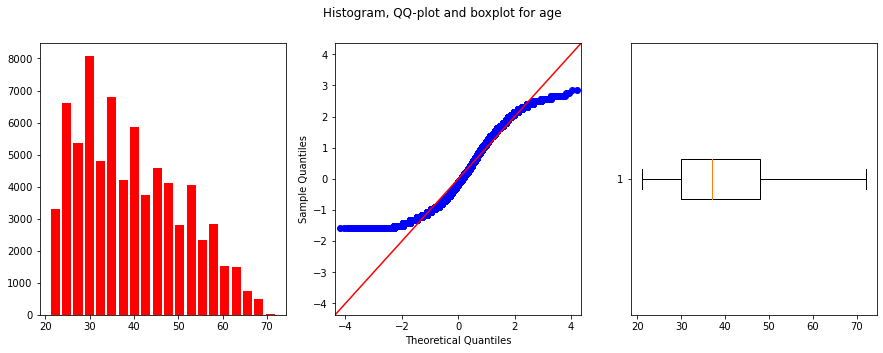

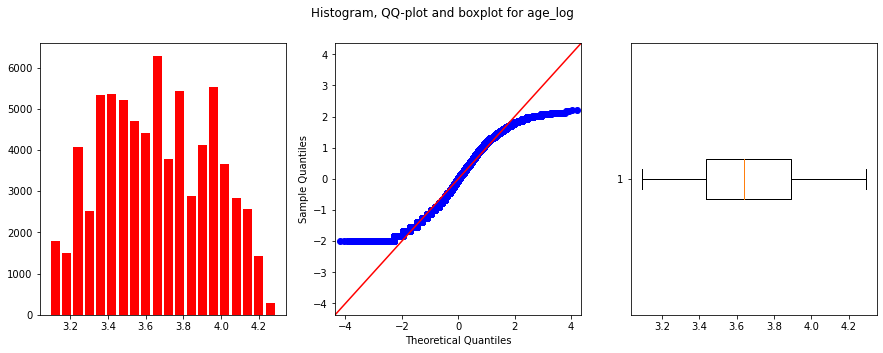

In [329]:
age = AnalyzNumCol(data[data.Train == 1], 'age')
age.show_plots()
age.show_plots(log = True)

**Вывод**

Признак распределен нормально. И выбросы отсутсвуют. Стоит отметить, что после логорифмирования признак к стал стремиться еще больше к нормальности. 

Таким образом логорифмируем признак age

In [330]:
data.age = (data.age + 1).transform(np.log)

### 3.2 Decline_app_cnt

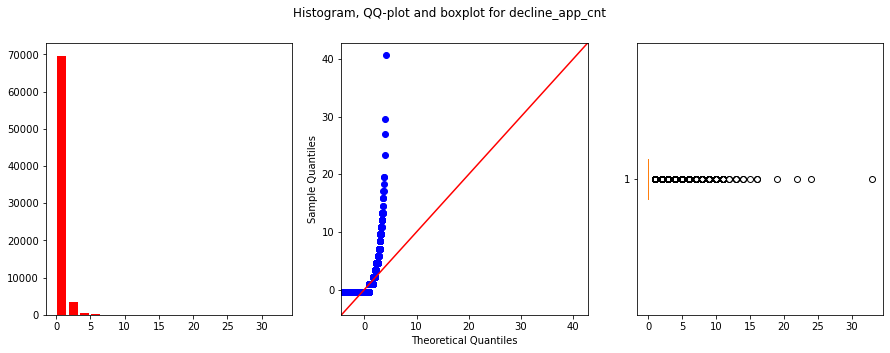

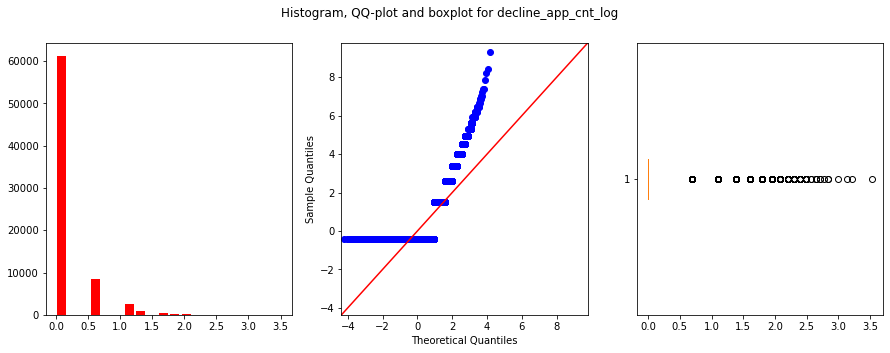

In [331]:
decline_app_cnt = AnalyzNumCol(data[data.Train == 1], 'decline_app_cnt')
decline_app_cnt.show_plots()
decline_app_cnt.show_plots(log = True)

**Вывод**

В признаке decline_app_cnt наблюдается сильное смещение. Применение логорифмирования улучшело данный признак 

Просмотрим выбросы

In [332]:
print('Суммарное количество выбросов для decline_app_cnt: ', decline_app_cnt.amount_emissions())
print('Суммарное количество выбросов для log(decline_app_cnt): ', decline_app_cnt.amount_emissions(log = True))

Суммарное количество выбросов для decline_app_cnt:  12585
Суммарное количество выбросов для log(decline_app_cnt):  12585


In [333]:
data.decline_app_cnt = (data.decline_app_cnt + 1).transform(np.log)

Так как в основе данного признака лежит отказ в кредитовании, то можно создать либо бинарный признак был отказ или не был отказ или категориальный признак: не было отказа (0), 1 отказ (1) и 2 и более отказов (2). Исходя из предыдущего анализа добавим бинарный признак

In [334]:
data['decline_yes'] = data.decline_app_cnt.apply(lambda x: 0 if x < 1 else 1)

### 3.3 Score_bki

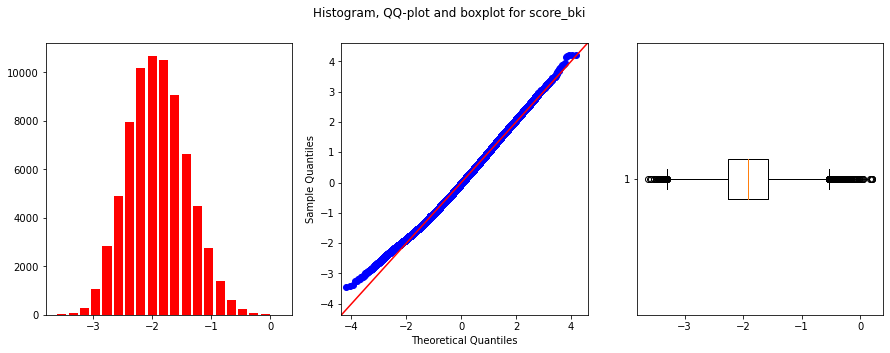

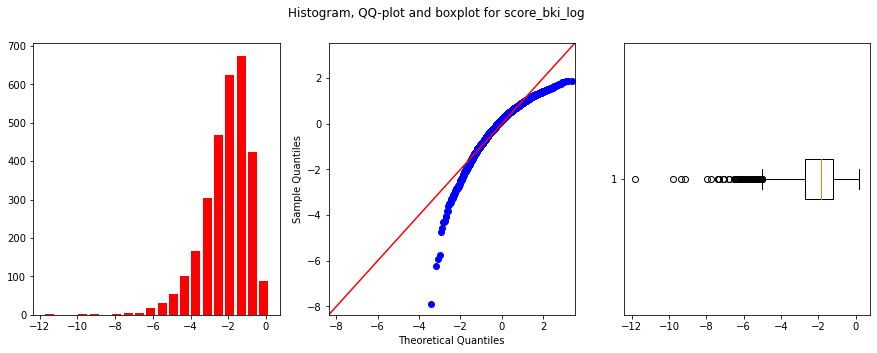

In [335]:
score_bki = AnalyzNumCol(data[data.Train == 1], 'score_bki')
score_bki.show_plots()
score_bki.show_plots(log=True)

Вывод

Признак нормально распределен но у него большое количество выбрасов. Посмотрим количество выбросов

In [336]:
print('Суммарное количество выбросов для score_bki: ', score_bki.amount_emissions())
print('Суммарное количество выбросов для log(score_bki): ', score_bki.amount_emissions(log = True))

Суммарное количество выбросов для score_bki:  351
Суммарное количество выбросов для log(score_bki):  85


**Вывод**
Признак логорифмировать не будем, удалять выбросы не будем т.к. их небольшое количество

### 3.4 bki_request_cnt

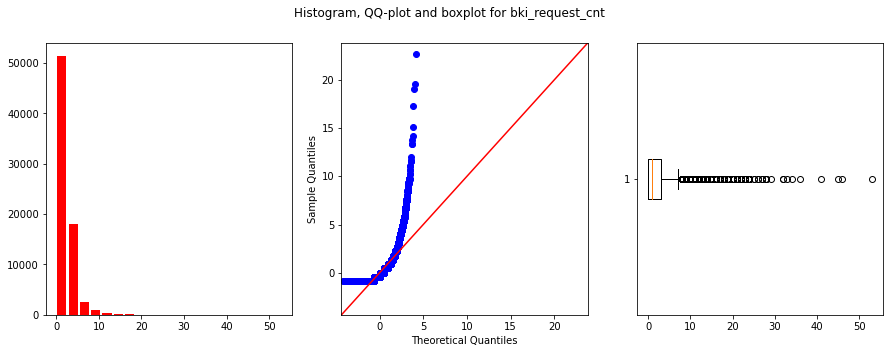

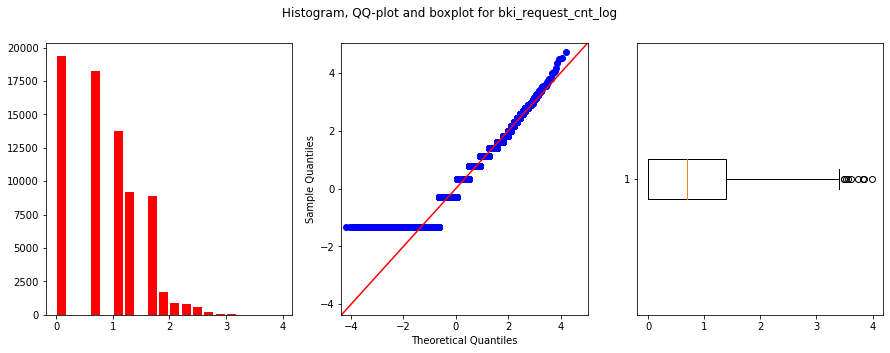

In [337]:
bki_request_cnt = AnalyzNumCol(data[data.Train == 1], 'bki_request_cnt')
bki_request_cnt.show_plots()
bki_request_cnt.show_plots(log = True)

**Вывод**

При логорифмировании критерий становиться ближе к нормальному распределению. У нас есть выбросы, которые необходимо дополнительно обработать

In [338]:
print('Суммарное количество выбросов для bki_request_cnt: ', bki_request_cnt.amount_emissions())
print('Суммарное количество выбросов для log(bki_request_cnt): ', bki_request_cnt.amount_emissions(log = True))

Суммарное количество выбросов для bki_request_cnt:  1755
Суммарное количество выбросов для log(bki_request_cnt):  9


После логорифмирования количество выбросов существенно уменьшилось.

In [339]:
data.bki_request_cnt = (data.bki_request_cnt + 1).transform(np.log)

### Income

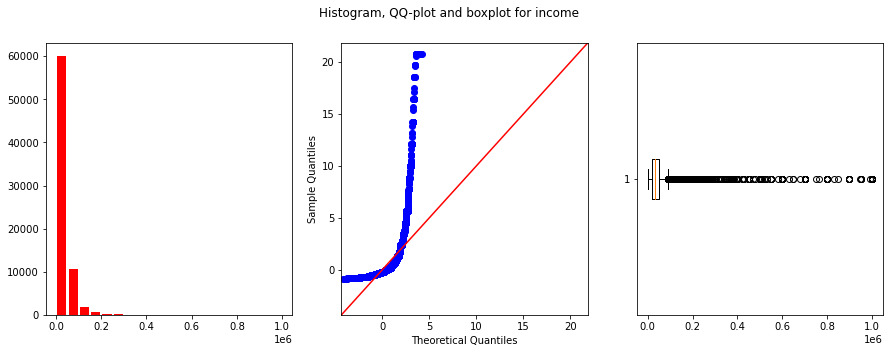

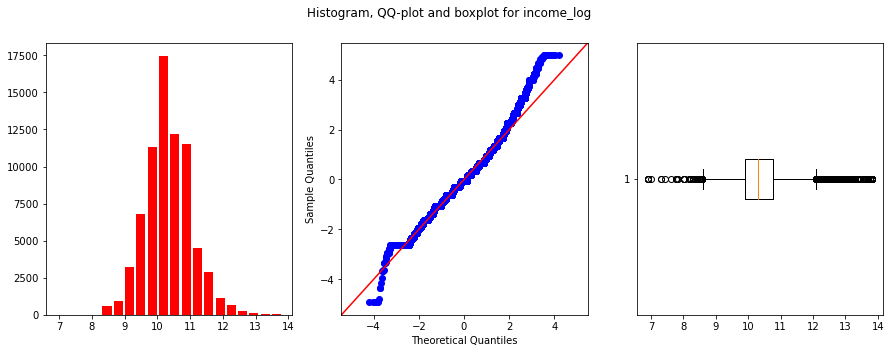

In [340]:
income = AnalyzNumCol(data[data.Train == 1], 'income')
income.show_plots()
income.show_plots(log = True)

**Вывод**: 
Логорифмирование существенно улучшило распределение признака, прологорифмируем признак и проверем количество пропусков

In [341]:
print('Суммарное количество выбросов для income: ', income.amount_emissions())
print('Суммарное количество выбросов для log(income): ', income.amount_emissions(log = True))

Суммарное количество выбросов для income:  4695
Суммарное количество выбросов для log(income):  1767


In [342]:
data.income = data.income.transform(np.log)

In [343]:
#data.income = data.income.transform(np.log)
# optional!
#for column in set(num_cols)-set(["score_bki","income"]):
#    print(column)
#    data[column] = (data[column]+1).transform(np.log)

### Delta_time

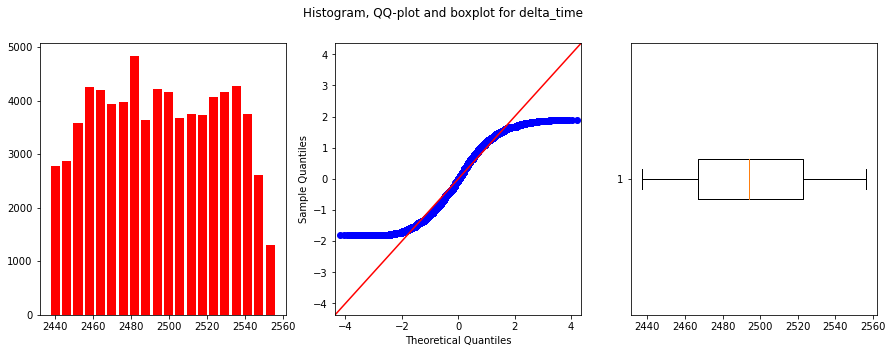

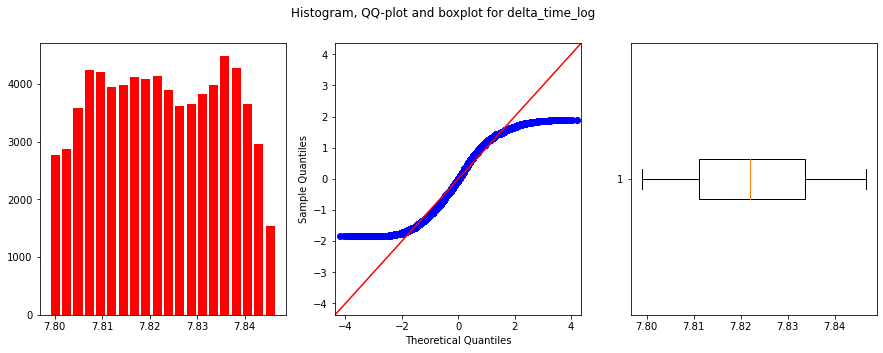

In [344]:
delta_time = AnalyzNumCol(data[data.Train == 1], 'delta_time')
delta_time.show_plots()
delta_time.show_plots(log = True)

Логорифмирование никак не повлияли на признак, выбросов у признака нет

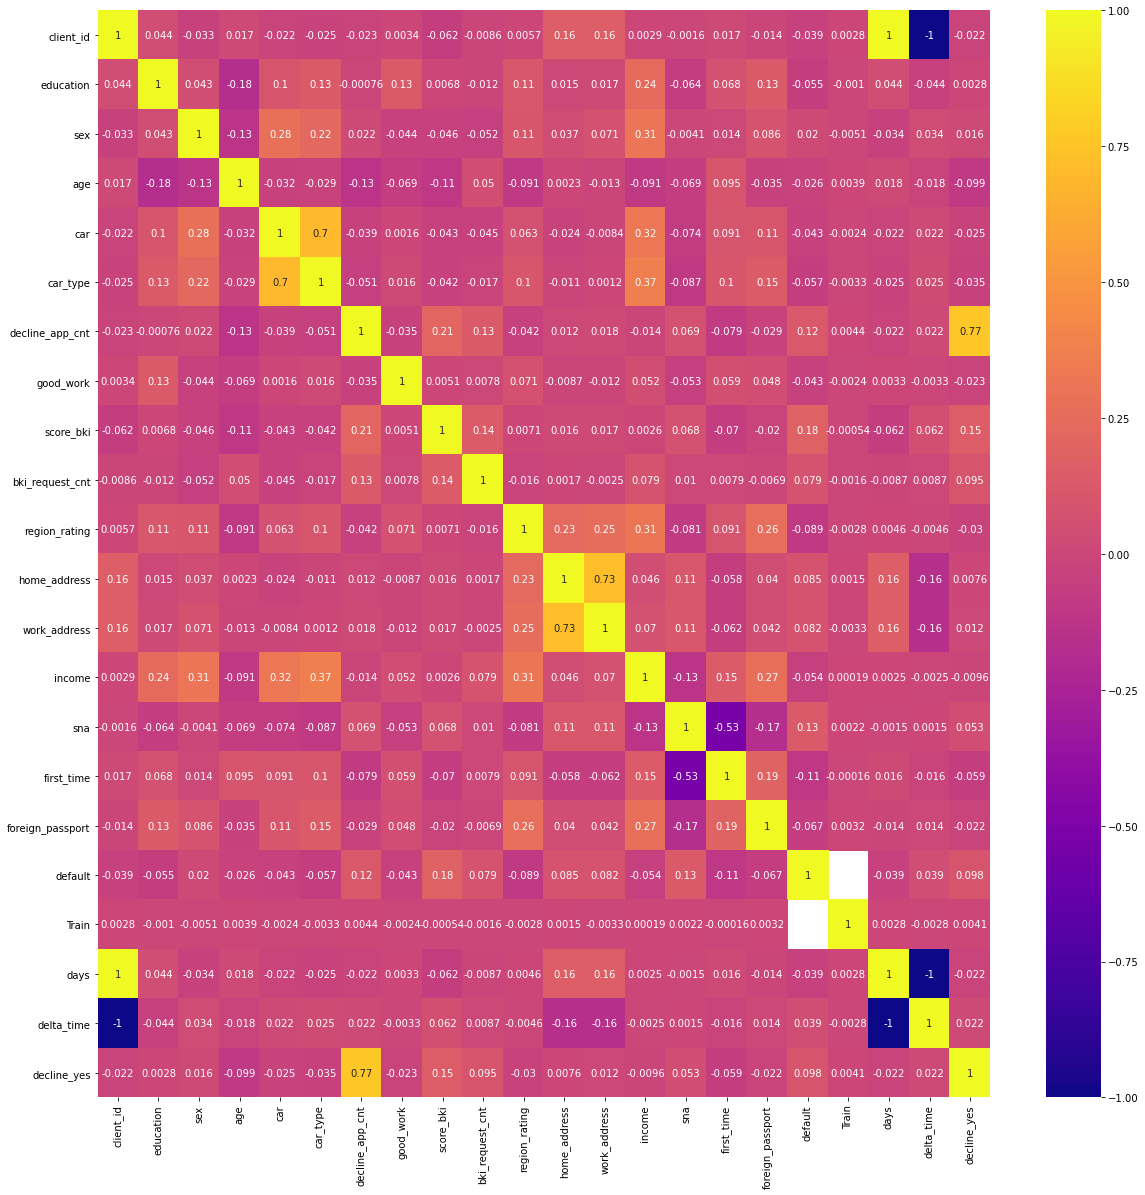

In [345]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
ax = sns.heatmap(data.corr(),annot = True, cmap = 'plasma')

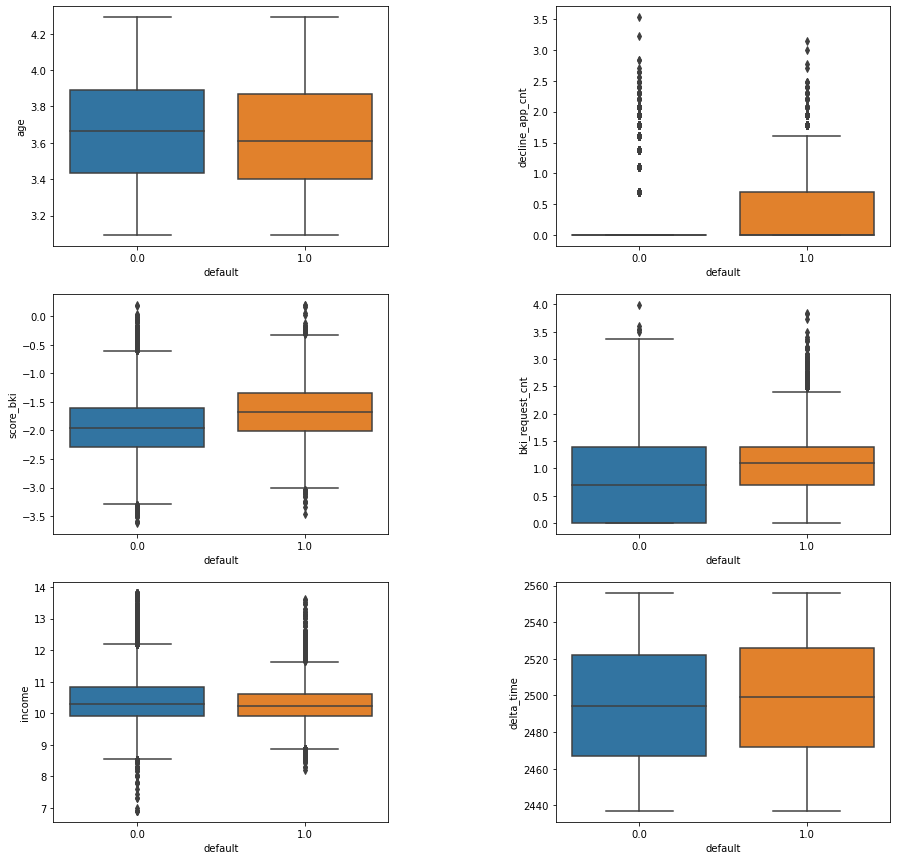

In [347]:
# Построим boxplot’ы для численных переменных
fig, axes = plt.subplots(3, 2, figsize=(15,15))
plt.subplots_adjust(wspace = 0.5)
axes = axes.flatten()

for i in range(len(num_cols)-1):
    sns.boxplot(x="default", y=num_cols[i], data=data[data.Train == 1], orient = 'v', ax=axes[i])

**Вывод**

* Средний возраст дефолтных клиентов ниже, чем у не дефолтных.
* Количество отказанных прошлых заявок выше для для дефолтных клиентов.
* Скоринговый балл по данным из БКИ выше для дефолтных.
* Количество запросов в БКИ для дефолтных значительно больше.
* Доход для дефолтных меньше.
* Дефолтные клиенты в среднем дальше от сегодняшнего дня.

In [472]:
train = data[data.Train == 1]
#Попытка убрать неинформативные признаки
train = train.drop(['Train'], axis=1)
X, y = prepare_space_with_poly(train, num_cols, bin_cols, cat_cols, target,StandardScaler())

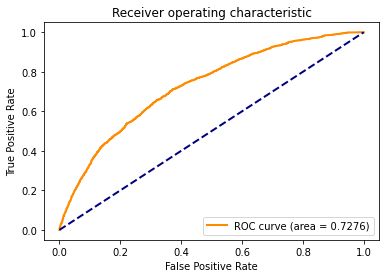

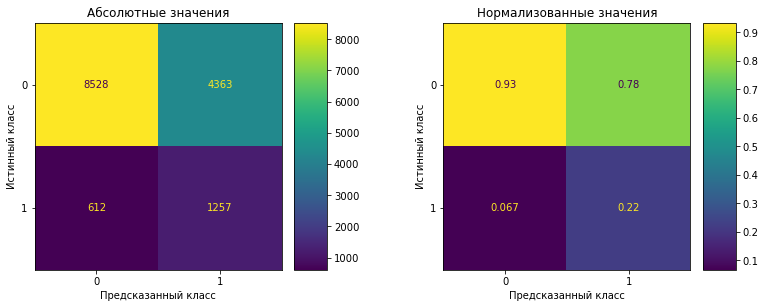

In [473]:
# Выделим из тренировочного датасета 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)
lr = LogisticRegression(
    class_weight='balanced',
    C = 7,
    max_iter = 800,
    random_state=RANDOM_SEED
).fit(X_train, y_train)
test_model_roc_cm(lr, X_test,y_test)

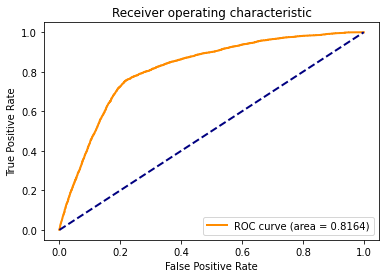

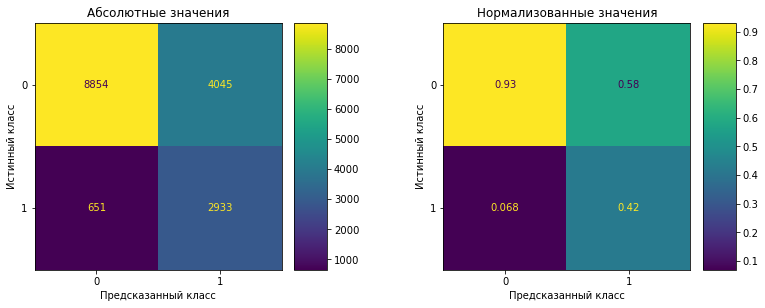

In [489]:
X, y = prepare_space_with_poly(train, num_cols, bin_cols, cat_cols, target,StandardScaler())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

'''model = LogisticRegression(
    #C = 7.742636826811269,
    class_weight='balanced',
    C = 66,
    max_iter = 800,
    solver='liblinear',
    penalty = 'l2',
    random_state=RANDOM_SEED
).fit(X_train, y_train)
'''
test_model_roc_cm(lr, X_test,y_test)

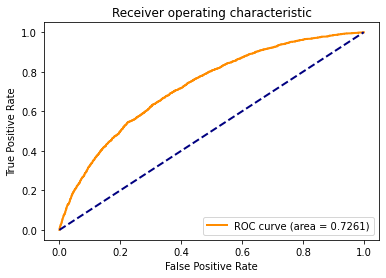

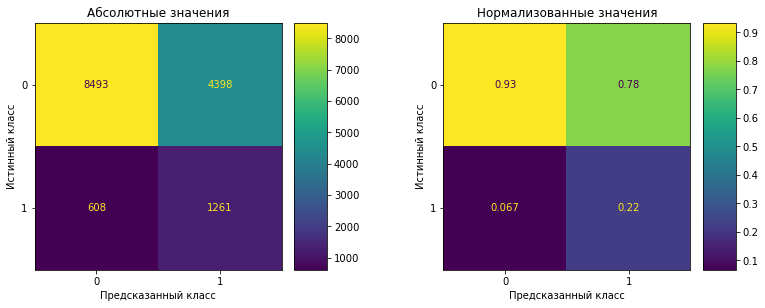

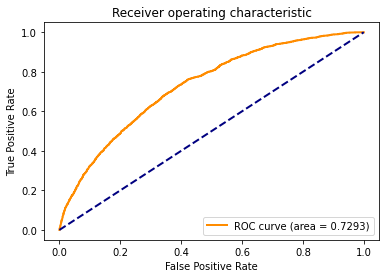

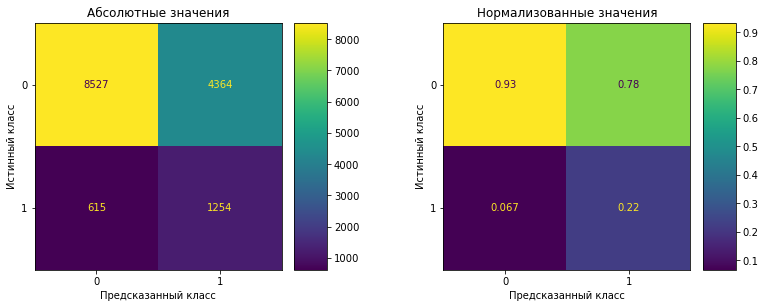

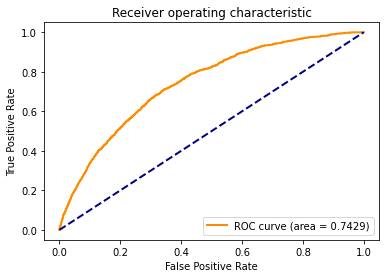

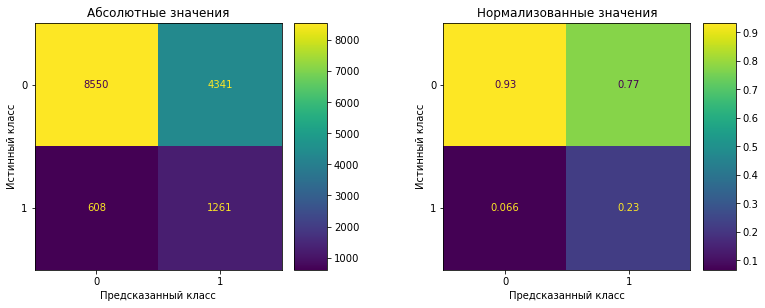

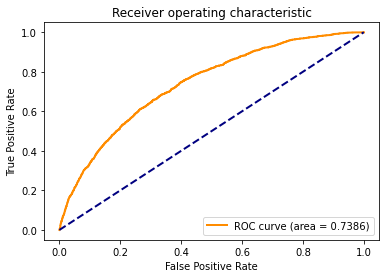

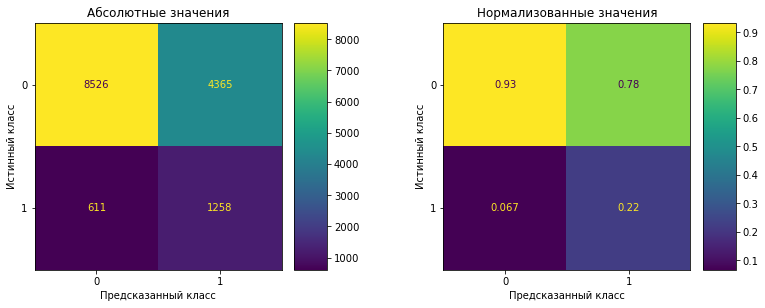

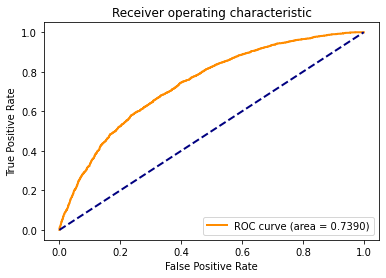

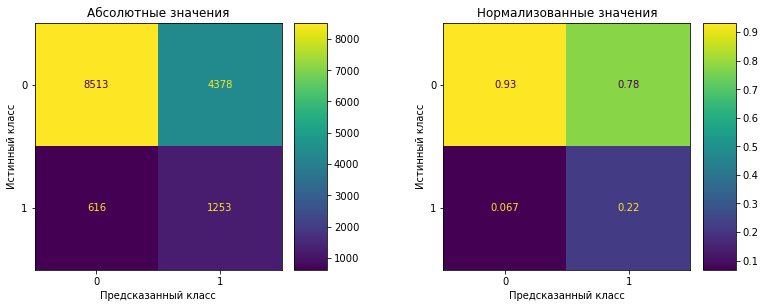

In [481]:
train = data[data.Train == 1]
#Попытка убрать неинформативные признаки
train = train.drop([ 'Train'], axis=1)
X, y = prepare_space_with_poly(train, num_cols, bin_cols, cat_cols, target,StandardScaler())

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
for fold,(idxT, idxV) in enumerate(kf.split(X, y)):
    lr = LogisticRegression(
    class_weight='balanced',
    C = 7,
    max_iter = 800,
    random_state=RANDOM_SEED).fit(X[idxT], y[idxT])
    test_model_roc_cm(lr, X[idxV],y[idxV])

# 4. Inference

In [125]:
test = data[data.Train == 0]
test = test.drop(['Train'], axis = 1)
X, y = prepare_space_with_poly(test, num_cols, bin_cols, cat_cols, target,StandardScaler())

y_pred_prob = lr.predict_proba(X)[:,1]
submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv(f'submission_lr.csv', index=False)

In [365]:
new_train.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,sna,first_time,foreign_passport,default,days,delta_time,decline_yes,bki_age_reg,new_one,new_one1
0,0.0,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,...,4,1,0,0.0,31,2525,0,-24.241945,0.055257,1.000000
1,0.0,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,...,4,1,0,0.0,70,2486,0,-18.712106,0.019616,1.000000
2,0.0,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,...,1,4,1,0.0,31,2525,1,-34.575827,-0.432198,-0.432198
3,0.0,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,...,1,3,0,0.0,22,2534,0,-25.789416,-0.515788,1.000000
4,1.0,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,...,1,4,1,0.0,107,2449,0,-19.189829,-0.319830,-0.319830


In [490]:
train = data[data.Train == 1]
#Попытка убрать неинформативные признаки
train = train.drop(['Train'], axis=1)
X, y = prepare_space(train, num_cols, bin_cols, cat_cols, target,StandardScaler())

# specify training parameters via map
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
for fold,(idxT, idxV) in enumerate(kf.split(X, y)):
    
    train_pool = Pool(X[idxT], label=y[idxT])
    test_pool = Pool(X[idxV],label=y[idxV])
    
    #param = {'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'iterations':800,'metric_period' : 100}
    model = CatBoostClassifier(iterations=800,
                               metric_period=100,
                               
                               random_seed=RANDOM_SEED,
                               learning_rate=0.1,
                               
                               eval_metric='AUC',
                               use_best_model=True,
                               auto_class_weights='Balanced'
                               )
    model.fit(train_pool,eval_set=test_pool,use_best_model=True, verbose_eval=False)
    
    pred = model.predict_proba(X[idxV])[:,1]
    print(roc_auc_score(y[idxV], pred))
#cross_val_score(model,X, y, scoring='accuracy', cv=kf, n_jobs=-1)

0.8166705532181028
0.8149895241510305
0.8109155922727721
0.8149487094692024
0.8111590659573479


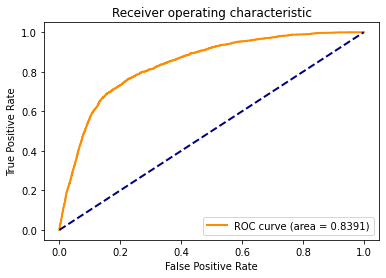

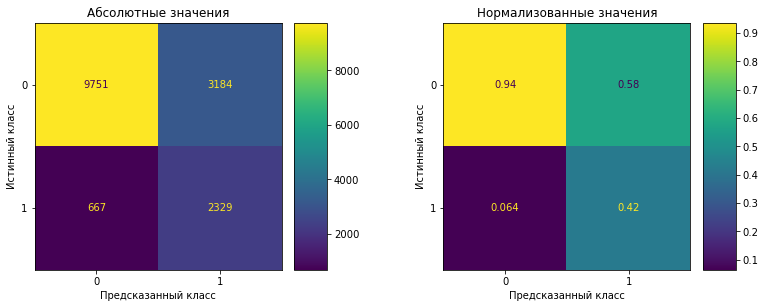

In [491]:
X, y = prepare_space_with_poly(train, num_cols, bin_cols, cat_cols, target,StandardScaler())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
test_model_roc_cm(model, X_test,y_test)

## INFERENCE

Model is  <bound method _CatBoostBase.is_fitted of <catboost.core.CatBoostClassifier object at 0x7fd62227e190>>
Model params  {'iterations': 800, 'learning_rate': 0.1, 'random_seed': 47, 'use_best_model': True, 'metric_period': 100, 'auto_class_weights': 'Balanced', 'eval_metric': 'AUC'}


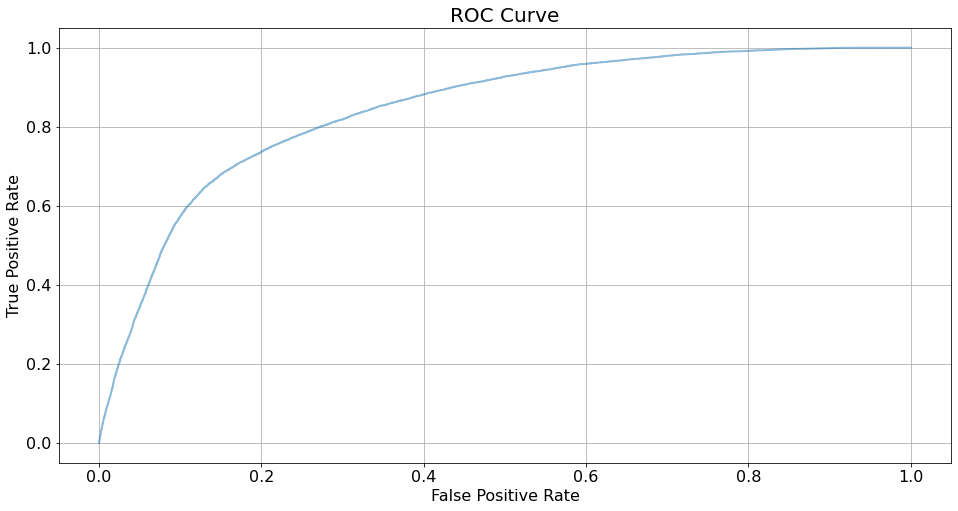

[0.        0.        0.        ... 0.9999612 0.9999806 1.       ]
[0.00000000e+00 8.20950661e-05 1.64190132e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[1.         0.96137608 0.96089365 ... 0.0054083  0.00507267 0.        ]


In [492]:
test = data[data.Train == 0]
test = test.drop(['client_id','Train'], axis = 1)

X, y = prepare_space_with_poly(test, num_cols, bin_cols, cat_cols, target,StandardScaler())
test_pool = Pool(X)

y_pred_prob = model.predict_proba(test_pool)[:,1]
submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv(f'submission_catboost8391.csv', index=False)
print('Model params ',model.get_params())
(fpr, tpr, thresholds) = get_roc_curve(model, train_pool, plot=True)


In [ ]:
train = data[data.Train == 1]
#Попытка убрать неинформативные признаки
train = train.drop(['client_id', 'Train'], axis=1)
X, y = prepare_space_with_poly(train, num_cols, bin_cols, cat_cols, target,StandardScaler())

train_pool = Pool(X, y)
param = {'iterations' : 800}
model = CatBoost(param)
grid = {
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

grid_search_results = model.grid_search(grid, train_pool, shuffle=False, verbose=3, plot=True)

In [ ]:
grid_search_results['params']

In [ ]:
grid_search_results['cv_results'].keys()

In [ ]:
test = data[data.Train == 0]
test = test.drop(['Train'], axis = 1)
X, y = prepare_space_with_poly(test, num_cols, bin_cols, cat_cols, target,StandardScaler())

y_pred_prob = model.predict(X)[:,1]
submit = pd.DataFrame(df_test.client_id)
submit['default'] = y_pred_prob
submit.to_csv(f'submission_catboost.csv', index=False)

In [397]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0,
    'class_weight':'balanced'
}

In [442]:
import lightgbm
train = data[data.Train == 1]
#Попытка убрать неинформативные признаки
train = train.drop(['client_id', 'Train'], axis=1)
X, y = prepare_space_with_poly(new_train, num_cols, bin_cols, cat_cols, target,StandardScaler())

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
for fold,(idxT, idxV) in enumerate(kf.split(X, y)):
    
    train_data = lightgbm.Dataset(X[idxT], label=y[idxT])
    test_data = lightgbm.Dataset(X[idxV], label=y[idxV])

    model = lightgbm.train(parameters,
                           train_data,
                           valid_sets=test_data,
                           num_boost_round=5000,
                           early_stopping_rounds=50, verbose_eval = 0)
    lgb_predicted = model.predict(X[idxV])
    lg_preds = np.where(lgb_predicted > 0.5, 1, 0)
    print(roc_auc_score(y[idxV], lgb_predicted))


0.8151792965185286
0.8129868337924075
0.8002095433010328
0.8111113749069281
0.8058553550304947


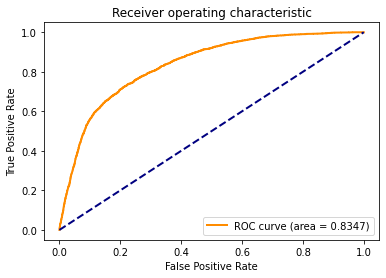

ValueError: plot_confusion_matrix only supports classifiers

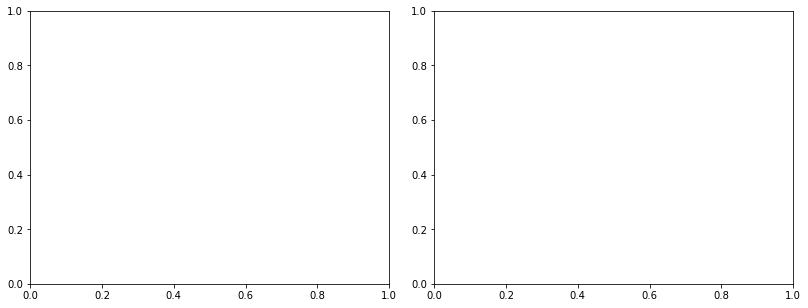

In [443]:
X, y = prepare_space_with_poly(train, num_cols, bin_cols, cat_cols, target,StandardScaler())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
test_model_roc_cm(model, X_test,y_test)

In [448]:
test = data[data.Train == 0]
test = test.drop(['client_id','Train'], axis = 1)

X, y = prepare_space_with_poly(test, num_cols, bin_cols, cat_cols, target,StandardScaler())


y_pred_prob = model.predict(X)
submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv(f'submission_lgmb.csv', index=False)

### HyperTuning for LGBM

In [ ]:
# other scikit-learn modules
estimator = lgb.LGBMClassifier()

param_grid = {
    'class_weight':['balanced','None'],
    'num_leaves':[10, 31, 50, 70],
    'learning_rate': [0.01, 0.1,0.5, 1],
    'n_estimators': [20, 40, 60, 80],
    'random_state': [RANDOM_SEED]
}

gbm = GridSearchCV(estimator, param_grid, cv=5)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

## SVR

In [ ]:
from sklearn import svm
regr = svm.SVR().fit(X, y)
#test_model_roc_cm(regr, X_test,y_test)


In [ ]:
regr.score()

## Ridge

In [1]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5).fit(X, y)

test = data[data.Train == 0]
test = test.drop(['Train'], axis = 1)
X, y = prepare_space_with_poly(test, num_cols, bin_cols, cat_cols, target,StandardScaler()) 

y_pred_prob = reg.predict(X)#[:,1]

submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv(f'submission_ridge.csv', index=False)
test_model_roc_cm(reg, X_test,y_test)
reg.score(X_test,y_test)

NameError: name 'X' is not defined

# Another models 

In [ ]:
from sklearn import linear_model
from sklearn import tree
from sklearn.linear_model import TweedieRegressor
from sklearn.pipeline import Pipeline

In [ ]:
train = data[data.Train == 1]
X, y = prepare_space_with_poly(new_train, num_cols, bin_cols, cat_cols, target,StandardScaler()) 

In [ ]:
models = {'OLS': linear_model.LinearRegression(),
         'Lasso': linear_model.Lasso(),
         'Ridge': linear_model.Ridge(),
         'Bayesian Ridge Regression' : linear_model.BayesianRidge(),
         'TweedieRegressor': TweedieRegressor(power=1, alpha=0.5, link='log')
         'DecisionTreeRegressor':tree.DecisionTreeRegressor()
         }

test_models(models, X,y)

# Tunining hyperparams

In [ ]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}
tweedie_params ={'power':[0,1, 1.5, 2, 3],
                'alpha':[0.02,  0.05, 0.1, 0.3, 0.5, 0.6]}
models2 = {'OLS': linear_model.LinearRegression(),
           'Lasso': GridSearchCV(linear_model.Lasso(), 
                               param_grid=lasso_params).fit(X, y).best_estimator_,
           'Ridge': GridSearchCV(linear_model.Ridge(), 
                               param_grid=ridge_params).fit(X, y).best_estimator_,
           'TweedieRegressor': GridSearchCV(TweedieRegressor(), 
                               param_grid=tweedie_params).fit(X, y).best_estimator_}

In [ ]:
test_models(models2, X,y)

In [ ]:
lasso_params = {'fit__alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}
ridge_params = {'fit__alpha':[550, 580, 600, 620, 650]}

pipe1 = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.LinearRegression())])
pipe2 = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.Lasso())])
pipe3 = Pipeline([('poly', PolynomialFeatures()),
                 ('fit', linear_model.Ridge())])

models3 = {'OLS': pipe1,
           'Lasso': GridSearchCV(pipe2, 
                                 param_grid=lasso_params).fit(X , y).best_estimator_ ,
           'Ridge': GridSearchCV(pipe3, 
                                 param_grid=ridge_params).fit(X , y).best_estimator_,}

In [ ]:
test_models(models3,X, y)

## Bayesian Ridge Regression

In [ ]:
from sklearn import linear_model
bayridge = linear_model.BayesianRidge().fit(X, y)
bayridge.score(X_test,y_test)
#test_model_roc_cm(bayridge, X_test,y_test)

## Generalized Linear Regression

In [ ]:
from sklearn.linear_model import TweedieRegressor
Tweedie = TweedieRegressor(power=1, alpha=0.5, link='log').fit(X, y)
Tweedie.score(X_test,y_test)
test_model_roc_cm(bayridge, X_test,y_test)
test = data[data.Train == 0]
test = test.drop(['Train'], axis = 1)
X, y = prepare_space_with_poly(test, num_cols, bin_cols, cat_cols, target,StandardScaler()) 

y_pred_prob = Tweedie.predict(X)#[:,1]

submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv(f'submission_Tweedie.csv', index=False)
#test_model_roc_cm(Tweedie, X_test,y_test)

In [ ]:
# параметры подбирались согласно документации
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

C = np.logspace(-1, 4, 100)
iter_ = 800
epsilon_stop = 1e-4
 
hyperparameters = [
    {'penalty': ['l1'], 
     'C': C,
     'solver': ['liblinear', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'C': C,
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['elasticnet'], 
     'C': C,
     'solver': ['saga'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки

In [ ]:
train = data[data.Train == 1]
X, y = prepare_space(train, num_cols, bin_cols, cat_cols, target,StandardScaler()) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# Обучаем модель
gridsearch = GridSearchCV(model, hyperparameters, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model_best_params = gridsearch.best_estimator_

best_estimators=[]
#Добавляем в копилку
best_estimators.append(model_best_params)

best_params = model_best_params.get_params()
print(f'Лучшие значения параметров:') 
for param_name in best_params.keys():
        print(f'  {param_name} = {best_params[param_name]},')


In [ ]:
best_params['C']=2782.559402207126
best_params['class_weight']='None'
best_params['dual']=False
best_params['fit_intercept']=True
best_params['intercept_scaling']=1
best_params['l1_ration']=None
best_params['max_iter']=1000
best_params['multi_class']='auto'
best_params['n_jobs']=None
best_params['penalty']='l1'
best_params['random_state']=RANDOM_SEED
best_params['solver']='liblinear'
best_params['tol']=0.0001
best_params['verbose']=0
best_params['warm_start']=False

In [ ]:
model = LogisticRegression(
    C = best_params['C'],
    class_weight = best_params['class_weight'],
    dual = best_params['dual'],
    fit_intercept = best_params['fit_intercept'],
    intercept_scaling = best_params['intercept_scaling'],
    l1_ratio = best_params['l1_ratio'],
    max_iter = best_params['max_iter'],
    multi_class = best_params['multi_class'],
    n_jobs = best_params['n_jobs'],
    penalty = best_params['penalty'],
    random_state = best_params['random_state'],
    solver = best_params['solver'],
    tol = best_params['tol'],
    verbose = best_params['verbose'],
    warm_start = best_params['warm_start']
)